In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.2
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.6.2
keras.api._v2.keras 2.6.0


In [4]:
# fashion_mnist图像分类数据集
fashion_mnist = keras.datasets.fashion_mnist

(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

x_valid, x_train = x_train_all[:5000], x_train_all[5000:]  # 自定义验证集样本数量5000
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# 得到的是np，训练集，验证集，测试集
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [5]:
28*28  # 如果非要对应多少特征，就是784个特征

784

In [6]:
type(x_train)

numpy.ndarray

In [7]:
y_train[0]

4

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  44 127 182 185 161 120  55
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42 198 251 255 251 249 247 255 252
  214 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 233 252 237 239 234 237 235 237 237
  254 227   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   2   0   0  16 210 225 215 175 217 216 193 196 226
  221 209  50   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   0 199 229 232 230 245 204 219 253 245 207 194
  223 231 236 235   0   0   3   0   0   0]
 [  0   0   0   0   1   0 137 235 204 209 201 209 234 190 234 218 215 238
  239 204 189 224 154   0   0   0   0   0]
 [  0   0   0   0   0   0 194 201 200 209 202 193 205 194 183 218 231 197
  172 181 193 205 199   0   0   0   0   0]
 [  0   0   0   0   0   3 212 203 188 189 196 198 198 201 196 21

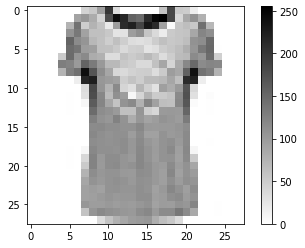

184
0


In [9]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary")
    plt.colorbar()  # 旁边显示一个色阶条
    plt.show()


# 依次看一下x_train[0]，x_train[1]，x_train[2]就可以理解下面的循环
print(x_train[0])
show_single_image(x_train[1])
print(x_train[1,0,18])
print(y_train[1])

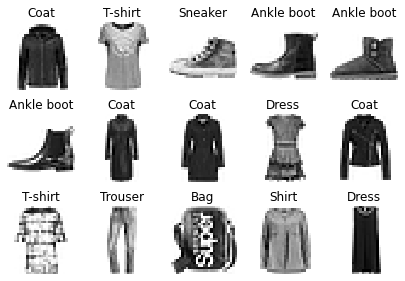

In [10]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)  # 断言：x和y的样本数一致（可以预料到的异常）
    assert n_rows * n_cols < len(x_data)  # 确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  # 宽1.4高1.6
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col 
            plt.subplot(n_rows, n_cols, index+1)  # 因为从1开始
            plt.imshow(x_data[index], cmap="binary",
                       interpolation = 'nearest')
            plt.axis('off')  # 去除坐标系
            plt.title(class_names[y_data[index]])
    plt.show()
# 已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
# 只是打印了前15个样本
show_imgs(3, 5, x_train, y_train, class_names)


In [11]:
# tf.keras.models.Sequential(),可以看下官网
# 功能：Sequential将线性的层堆叠到一个tf.keras.Model

model = keras.models.Sequential()
# 把28*28的图片展平为一个一维向量,通过下面打印可以看到两个相乘
model.add(keras.layers.Flatten(input_shape=[28, 28]))
print(model.output_shape)

# Dense是全连接层，添加全连接层，单元数是300，可以对比300和100的差异
# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# 另一种实现方式
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])



# reason for sparse: y->index. y->one_hot->[] 
# loss是损失函数 y如果只是一个数，那么使用sparse_categorical_crossentropy
# sparse_categorical_crossentropy计算稀疏分类crossentropy损失
# 计算的分类值是 0,1,2,...9
# 如果是一个向量，那么使用categorical_crossentropy
# optimizer是优化方法，
# metrics：模型在训练和测试期间要评估的指标列表（算子）
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

(None, 784)


In [12]:
model.layers  #总计有4层

In [14]:
# 计算参数个数
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [16]:
784*300+300

235500

In [18]:
model.variables  # 模型中自己训练的参数

[<tf.Variable 'dense/kernel:0' shape=(784, 300) dtype=float32, numpy=
 array([[ 0.02790184, -0.053971  ,  0.04498359, ...,  0.04016154,
          0.00279552,  0.00715348],
        [ 0.05336918, -0.03115787, -0.05868514, ..., -0.05703015,
          0.07320587, -0.0235216 ],
        [ 0.03272563, -0.02139258, -0.03117651, ..., -0.06082131,
          0.03824086, -0.02551881],
        ...,
        [ 0.0404781 ,  0.07017966,  0.06000574, ..., -0.01211173,
          0.01544213,  0.00537414],
        [-0.0383571 ,  0.0369855 , -0.06333514, ...,  0.04344299,
          0.06792736,  0.00282654],
        [-0.03192933, -0.03834044, -0.03912156, ...,  0.05728087,
          0.07348707, -0.00014652]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(300,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [19]:
# 均匀分布
np.sqrt(6/300)

0.1414213562373095

In [20]:
model.variables[0].numpy().max()

0.07439551

In [22]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]
# W是矩阵，b是一个偏置，是一个向量

In [23]:
# 训练20次，每一次所有的样本都输进去（再分成默认32批次）
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_valid, y_valid))  

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 3.1869 - accuracy: 0.7072 - val_loss: 0.6739 - val_accuracy: 0.7484
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5903 - accuracy: 0.7916 - val_loss: 0.6032 - val_accuracy: 0.7852
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5085 - accuracy: 0.8185 - val_loss: 0.5698 - val_accuracy: 0.8130
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4670 - accuracy: 0.8305 - val_loss: 0.4928 - val_accuracy: 0.8342
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4404 - accuracy: 0.8405 - val_loss: 0.5008 - val_accuracy: 0.8268
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4221 - accuracy: 0.8462 - val_loss: 0.4618 - val_accuracy: 0.8402
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4074 - accuracy: 0.8513 - val_loss: 0.4671 - val_accuracy:

In [24]:
type(history)

keras.callbacks.History